In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib as mp
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import curve_fit
import sympy
from sympy import diff,sin,exp,log,integrate,sqrt
from sympy.abc import t,T,Q

ModuleNotFoundError: No module named 'sympy'

In [2]:
print(pd.__version__)
print(np.__version__)

1.0.3
1.17.3


Импортируем файл с параметрами образцов, получаем значения плотностей абсолютной и относительной.

In [3]:
dens=pd.read_excel('Sample parameters_1350.xlsx')
new_names={0:'d,mm',1:'h,mm',2:'m,g',3:'V',4:'density_old'}
dens.rename(columns=new_names, inplace=True)
dens.loc[0,'h,mm']=2.877020453
dens['r,cm']=dens['d,mm']/20
dens['h,cm']=dens['h,mm']/10
dens['V,cm^3']=np.pi*dens['h,cm']*dens['r,cm']**2
dens['density_new, g/cm^3']=dens['mass, g']/dens['V,cm^3']
dens['relative density']=dens['density_new, g/cm^3']*100/(0.6*2.822+0.4*3.12)
dens

,Status,Temperature,Rate,"mass, g","h,mm","d,mm","r,cm","h,cm","V,cm^3","density_new, g/cm^3",relative density
0,Before sintering,1350,1,0.28259,2.87702,8.07,0.4035,0.287702,0.147157,1.920335,65.290851
1,Before sintering,1350,2,0.28248,2.78000,8.09,0.4045,0.278000,0.142900,1.976769,67.209618
2,Before sintering,1350,5,0.29842,2.90000,8.06,0.4030,0.290000,0.147965,2.016833,68.571777
3,Before sintering,1350,10,0.35820,3.54000,8.07,0.4035,0.354000,0.181067,1.978269,67.260611
4,Before sintering,1350,20,0.26084,2.67000,8.08,0.4040,0.267000,0.136906,1.905243,64.777737
5,After sintering,1350,1,0.26980,2.64000,7.51,0.3755,0.264000,0.116943,2.307110,78.441106
6,After sintering,1350,2,0.28285,2.55000,7.46,0.3730,0.255000,0.111457,2.537748,86.282736
7,After sintering,1350,5,0.29855,2.65000,7.41,0.3705,0.265000,0.114281,2.612431,88.821959
8,After sintering,1350,10,0.35850,3.19000,7.36,0.3680,0.319000,0.135718,2.641514,89.810768
9,After sintering,1350,20,0.26115,2.50000,7.59,0.3795,0.250000,0.113113,2.308748,78.496814


Импортируем данные с дилатометра. Три колонки: "Температура, С"; "Время, мин"; "dL/L0". Сражу же вычитаем коррекцию из съемки непосредственно образца.

In [4]:
def import_data(filename, filename_corr):
    data=pd.read_csv(filename, sep=';', header=24, names=['Temperature, C','Time, min','dL/L0'])
    data_corr=pd.read_csv(filename_corr, sep=';', header=24, names=['Temperature, C','Time, min','dL/L0'])
    data['dL/L0_corr']=data['dL/L0']-data_corr['dL/L0']
    return data

In [5]:
df_1=import_data('000401_K06_1_1350_Air-static.txt', '000407_correction_saphire_1_1350_Air-static.txt')
df_2=import_data('000398_K06_2_1350_Air-static.txt', '000392_correction_saphire_2_1450_Air-static.txt')
df_5=import_data('000397_K06_5_1350_Air-static.txt', '000396_correction_saphire_5_1350_Air-static.txt')
df_10=import_data('000402_K06_10_1335_Air-static.txt', '000403_correction_saphire_10_1350_Air-static.txt')
df_20=import_data('000393_K06_20_1450_Air-static.txt', '000391_correction_saphire_20_1450_Air-static.txt')

In [6]:
df_1.tail()

,"Temperature, C","Time, min",dL/L0,dL/L0_corr
62875,1350.43604,1309.91663,-0.072243,-0.082421
62876,1350.44897,1309.93750,-0.072238,-0.082414
62877,1350.46399,1309.95837,-0.072234,-0.082411
62878,1350.48303,1309.97913,-0.072210,-0.082384
62879,1350.50806,1310.00000,-0.072232,NaN


Просто строим графики зависимости усадки всех образцов от температуры.

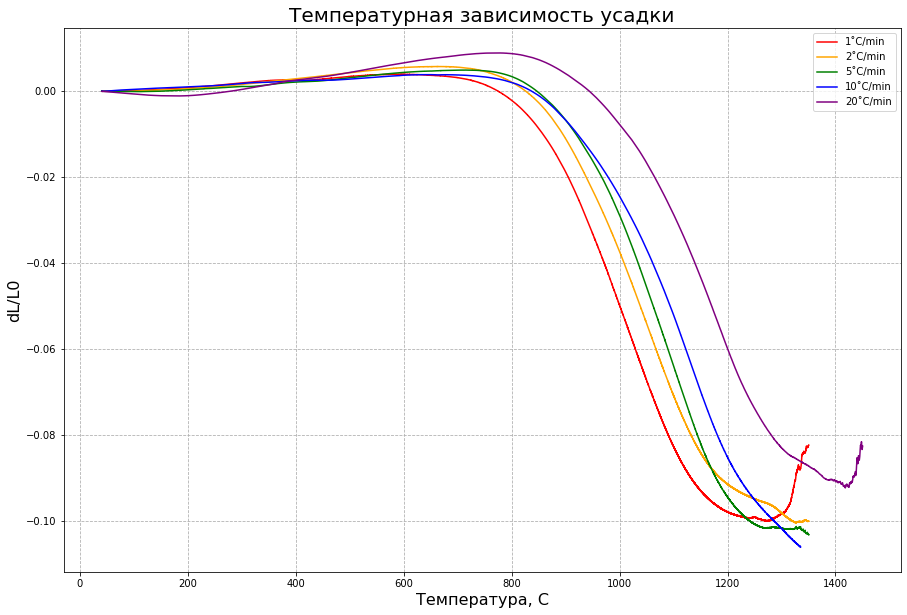

In [7]:
rate_list=[1,2,5,10,20]
colors=['red','orange','green','blue','purple']
dil_list=[df_1,df_2,df_5,df_10,df_20]
fig,ax=plt.subplots(figsize=(15,10))
for data,color,rate in zip(dil_list,colors,rate_list):
    ax.plot(data['Temperature, C'],data['dL/L0_corr'], color=color,label=(str(rate)+'˚C/min'))
ax.grid(linestyle='--')
ax.set_title('Температурная зависимость усадки', fontsize=20)
ax.set_xlabel('Температура, С',fontsize=16)
ax.set_ylabel('dL/L0',fontsize=16)
plt.legend()
plt.show()

Отрезаем кривые после момента выхода на плато, но до расширения из-за плавления. Выбираем единый температурный интервал для всех скоростей: 700-1300°С. 

In [8]:
t=700 #start temperature
tf=1301 #final temperature
df_1_corr=df_1.loc[df_1.index[df_1['Temperature, C']>t][0]:df_1.index[df_1['Temperature, C']<tf][-1],:].reset_index()
df_2_corr=df_2.loc[df_2.index[df_2['Temperature, C']>t][0]:df_2.index[df_2['Temperature, C']<tf][-1],:].reset_index()
df_5_corr=df_5.loc[df_5.index[df_5['Temperature, C']>t][0]:df_5.index[df_5['Temperature, C']<tf][-1],:].reset_index()
df_10_corr=df_10.loc[df_10.index[df_10['Temperature, C']>t][0]:df_10.index[df_10['Temperature, C']<tf][-1],:].reset_index()
df_20_corr=df_20.loc[df_20.index[df_20['Temperature, C']>t][0]:df_20.index[df_20['Temperature, C']<tf][-1],:].reset_index()

Строим зависимости усадки от температуры в выбранных интервалах для всех скоростей

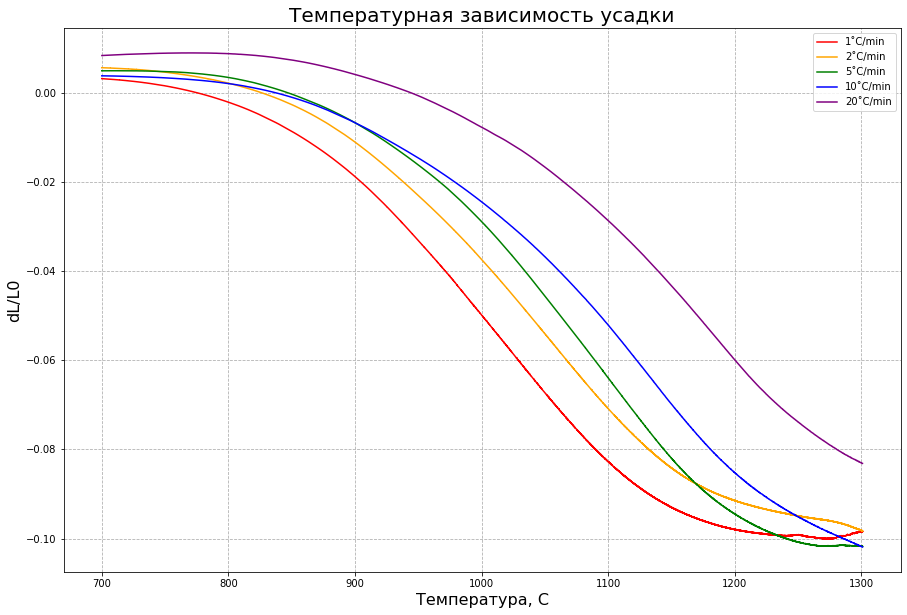

In [9]:
fig,ax=plt.subplots(figsize=(15,10))
data_list=[df_1_corr,df_2_corr,df_5_corr,df_10_corr,df_20_corr]

for i,j,rate in zip(data_list,colors,rate_list):
    ax.plot(i['Temperature, C'],i['dL/L0_corr'], color=j,label=(str(rate)+'˚C/min'))
ax.grid(linestyle='--')
ax.set_title('Температурная зависимость усадки', fontsize=20)
ax.set_xlabel('Температура, С',fontsize=16)
ax.set_ylabel('dL/L0',fontsize=16)
plt.legend()
plt.show()

Рассчитываем итоговую плотность исходя из начальной толщины образца, измеренной до установки в дилатометр,и конечной толщины, соответсвующей толщине образца в конце выбранного температурного интервала.

In [10]:
def real_density(rate, data,T):
    index=dens[(dens['Status']=='Before sintering') & (dens['Rate']==rate)]['h,mm'].index[0]
    h0=dens.loc[index,'h,mm']/10
    index=dens[(dens['Status']=='Before sintering') & (dens['Rate']==rate)]['mass, g'].index[0]
    m=dens.loc[index,'mass, g']
    index=dens[(dens['Status']=='Before sintering') & (dens['Rate']==rate)]['d,mm'].index[0]
    rf=dens.loc[index,'d,mm']/20
    dL=data.loc[data.index[data['Temperature, C']<T][-1],'dL/L0_corr']*1E-4
    pof=m/(np.pi*rf**2*(h0+dL))
    return pof

final_density_list=[]
for rate,data in zip(rate_list,data_list):
    final_density_list.append(real_density(rate, data,1300))

Рассчитываем изменение относительной плотности в процессе усадки и строим зависимость относительной плотности от температуры.

In [11]:
def real_density_calc(data,rate):
    index=dens[(dens['Status']=='Before sintering') & (dens['Rate']==rate)]['density_new, g/cm^3'].index[0]
    p0=dens.loc[index,'density_new, g/cm^3']
    data['Rel Density']=((1/(1+data['dL/L0_corr']))**3)*p0/(0.6*2.822+0.4*3.12)
    return data

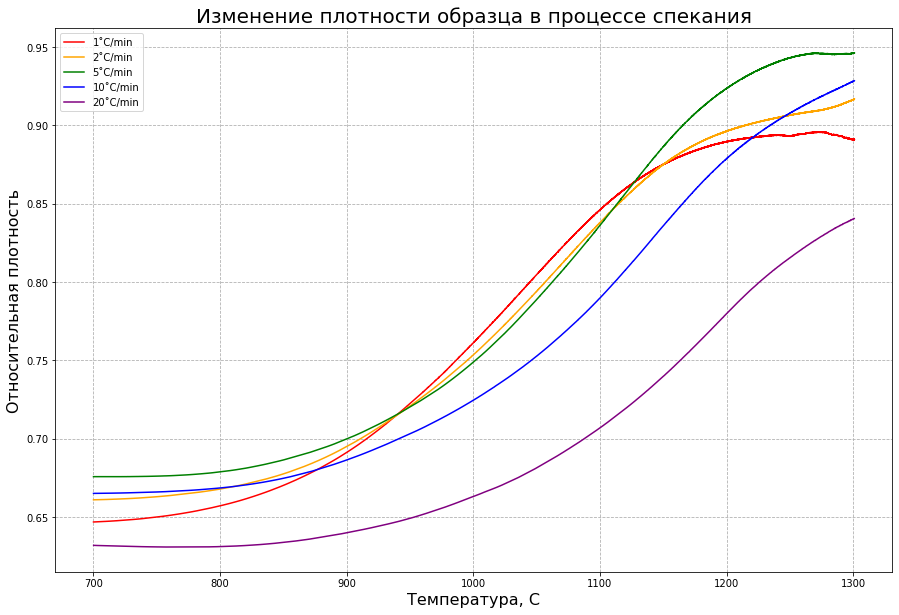

In [12]:
for data,rate in zip(data_list,rate_list):
    data=real_density_calc(data,rate)
    
fig,ax=plt.subplots(figsize=(15,10))
for i,j,rate in zip(data_list,colors,rate_list):
    ax.plot(i['Temperature, C'],i['Rel Density'], color=j,label=(str(rate)+'˚C/min'))
ax.grid(linestyle='--')
ax.set_title('Изменение плотности образца в процессе спекания', fontsize=20)
ax.set_xlabel('Температура, С',fontsize=16)
ax.set_ylabel('Относительная плотность',fontsize=16)
plt.legend()
plt.show()

In [13]:
#np.savetxt(r'out_1.txt', df_1_corr.values, fmt='%f5')



Построение результатов, рассчитанных из экселевского макроса Tang2002.

In [14]:
temp_list=np.arange(700,1349,50)
#names=[out_1,out_2,out_5','out_10']

for k in data_list:

    k['RD100']=k['Rel Density']*100
    k['Time, sec']=k['Time, min']*60
    #for i in temp_list:
    #    k.iloc[k.index[k['Temperature, C']>i][0],:].values[0]

In [15]:
a=pd.DataFrame(columns=df_1_corr.columns)
k=df_20_corr
for i in range(len(temp_list)):
    a.loc[i,:]=k.iloc[k.index[k['Temperature, C']>=temp_list[i]][0],:].values
np.savetxt(r'out_20.txt', a.values, fmt='%f5')

In [16]:
names=np.arange(66,92,2)
calc_data=pd.read_csv('243kJ_calc data.csv', sep=';',names=names)
calc_data=calc_data/3600
temp=np.arange(700,1340,20)
calc_data['Temperature, C']=temp
#print(calc_data)
a=calc_data.iloc[20:26,7:calc_data.shape[1]-1].values

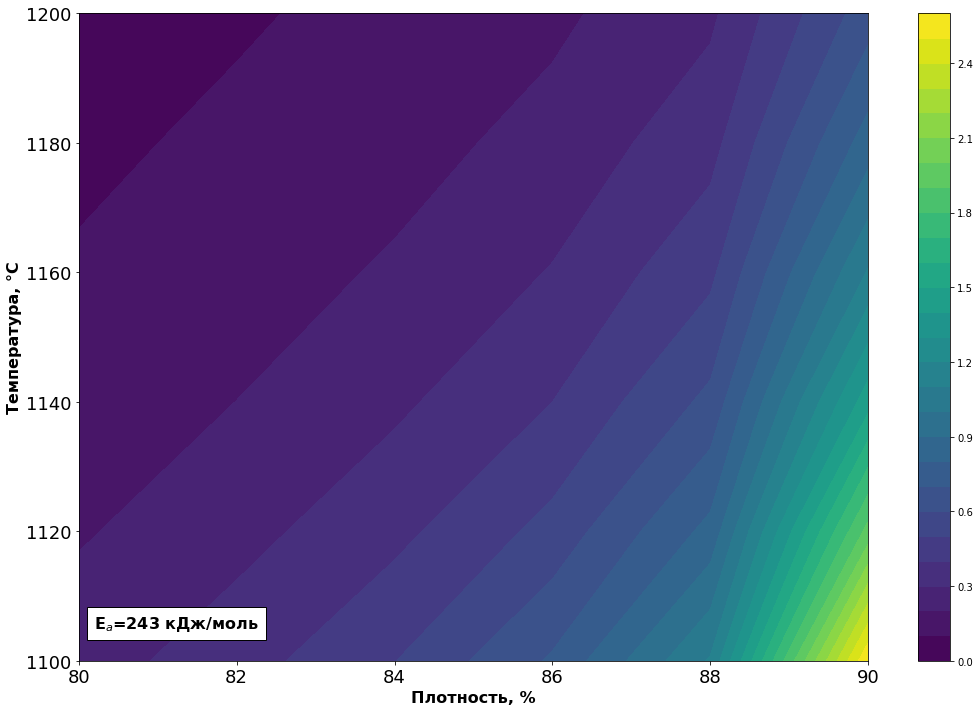

In [17]:
fig,ax=plt.subplots(figsize=(15,10))
x=np.arange(80,92,2)
y=np.arange(1100,1220,20)
a[a>1e4]=1e4
#cmap=mp.colors.ListedColormap(mp.cm.get_cmap("viridis").colors[::-1])
cs=plt.contourf(x,y, a,25, cmap="viridis")#,levels=np.arange(0,155,10))


ax.set_xlabel('Плотность, %',fontsize=16, weight='bold')
ax.set_ylabel('Температура, °С',fontsize=16, weight='bold')
#ax.clabel(cs, inline=True, inline_spacing=3, rightside_up=True, colors='k', fontsize=16)#,manual=[1])
fig.colorbar(cs)
ax.set_xticks(np.arange(80,92,2))
ax.set_xticklabels(np.arange(80,92,2),fontsize=18)
ax.set_yticks(np.arange(1100,1220,20))
ax.set_yticklabels(np.arange(1100,1220,20),fontsize=18)
ax.text(x[0]+0.2, y[0]+5, r'E$_a$=243 кДж/моль', style='normal',fontsize=16,weight='bold',
        bbox={'facecolor': 'white','pad':7})
plt.tight_layout()
plt.show()

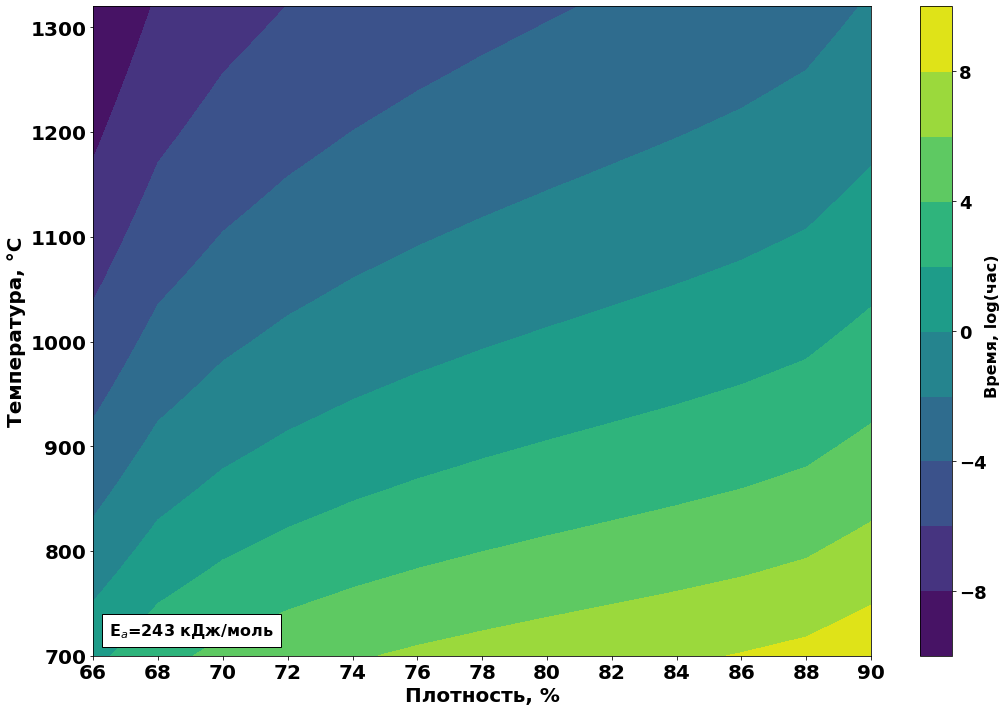

In [18]:
names=np.arange(66,92,2)
calc_data=pd.read_csv('243kJ_calc data.csv', sep=';',names=names)
calc_data=calc_data/3600
temp=np.arange(700,1340,20)
calc_data['Temperature, C']=temp
#print(calc_data)
a=np.log(calc_data.iloc[:,:calc_data.shape[1]-1].values)
#print(a)

fig,ax=plt.subplots(figsize=(15,10))
x=np.arange(66,92,2)
y=np.arange(700,1340,20)
#a[a>1e4]=1e4
cs=plt.contourf(x,y, a,10, cmap="viridis")

fontsize=20
ax.set_xlabel('Плотность, %',fontsize=fontsize, weight='bold')
ax.set_ylabel('Температура, °С',fontsize=fontsize, weight='bold')
cbar=fig.colorbar(cs)
cbar.ax.tick_params(labelsize=fontsize)
cbar.ax.set_yticklabels(labels=cbar.ax.get_yticklabels(), weight='bold', fontsize=18)
ax.set_xticks(np.arange(66,92,2))
ax.set_xticklabels(np.arange(66,92,2),fontsize=fontsize,weight='bold')
ax.set_yticks(np.arange(700,1340,100))
ax.set_yticklabels(np.arange(700,1340,100),fontsize=fontsize,weight='bold')
ax.text(x[0]+0.5, y[0]+20, r'E$_a$=243 кДж/моль', style='normal',fontsize=16,weight='bold',
        bbox={'facecolor': 'white','pad':7})
ax.text(x[-1]+3.5, y[0]+250, r'Время, log(час)', style='normal',fontsize=16,weight='bold',
        bbox={'facecolor': 'white','edgecolor':'none','pad':7},rotation=90,)
plt.tight_layout()
plt.show()

In [19]:
fig.savefig('MSC.png')

In [3]:
df=pd.read_excel('MSC Fit.xlsx')
df.head()

,log(theta),density,log(theta).1,Density Fit
0,-13.429566,63.084116,-14.104252,64.547657
1,-12.826939,63.105150,-13.974188,64.574004
2,-14.104252,63.182482,-13.844124,64.603758
3,-12.278899,63.372904,-13.714061,64.637361
4,-11.780312,63.986466,-13.583997,64.675311


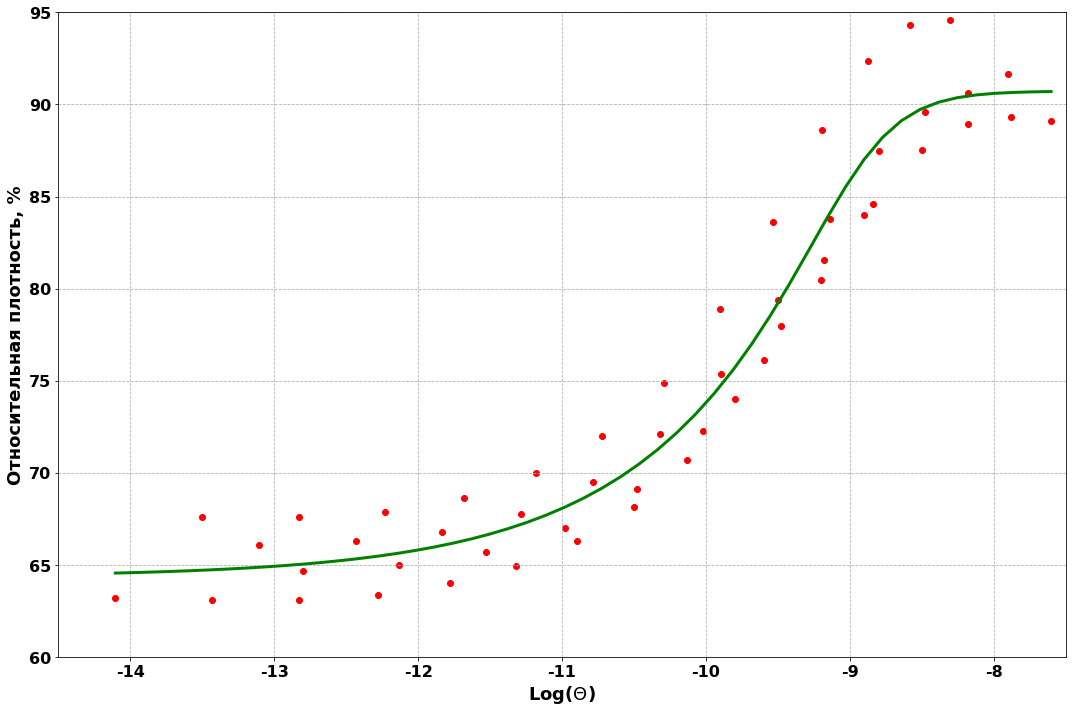

In [24]:
fig,ax=plt.subplots(figsize=(15,10))
fontsize=16
x=np.arange(-14.5,-7.5,1)
y=np.arange(60,100,5)
ax.scatter(df['log(theta)'],df['density'], color='red')
ax.plot(df['log(theta).1'],df['Density Fit'], color='green',linewidth=3)
#ax.set_xlim(-60,0)
ax.grid(linestyle='--')
#ax.set_title('Изменение плотности образца в процессе спекания', fontsize=20)
ax.set_xlabel('Log(${\Theta}$)',fontsize=fontsize+2, weight='bold')
ax.set_ylabel('Относительная плотность, %',fontsize=fontsize+2, weight='bold')
ax.set_xlim(-14.5,-7.5)
ax.set_ylim(60,95)
ax.set_xticks(np.arange(-14,-7,1))
ax.set_xticklabels(np.arange(-14,-7,1),fontsize=fontsize,weight='bold')
ax.set_yticks(np.arange(60,100,5))
ax.set_yticklabels(np.arange(60,100,5),fontsize=fontsize,weight='bold')
plt.tight_layout()
plt.show()

In [25]:
#fig.savefig('MSC_Fit.png')

### Функция для расчета работы спекания во взятом интервале температур.

Приводим температуру к Кельвинам и берем за начальное время время выранной начальной температуры (700°С).

In [113]:
for df in data_list:
    df['Temperature, C']=df['Temperature, C']+273
    df['Time, min']=df['Time, min']-df.loc[0,'Time, min']

Определяем функции для расчета интеграла Theta и функции ошибок.

In [116]:
#theta function
def theta_calculation(data,Q):
    theta_list=[]
    logtheta_list=[]
    R=8.31
    #рассчитываем подинтегральную функцию
    data['Func']=np.exp(-Q/R/data['Temperature, C'])/data['Temperature, C']
    #численно интегрируем
    theta=0
    for i in range((data.shape[0]-1)):
        theta=theta+(abs(data.loc[i+1,'Func']-data.loc[i,'Func']))*(data.loc[i+1,'Time, min']-data.loc[i,'Time, min'])
        theta_list.append(theta)
        logtheta_list.append(np.log(theta))
    #заполняем последние строчки последними значениями theta
    logtheta_list.append(np.log(theta))
    theta_list.append(theta)
    data['log Theta']=logtheta_list
    data['Theta']=theta_list
    return data
    
#error function for MSC
def error_function(data,p_start,p_final):
    N=len(data_list) #number of used rates
    p_integral=0
    for i in range(data.shape[0]):
        squares_theta=0
        for j in range(1,N+1):
            squares_theta+=(data.iloc[i,j]/np.mean(data.iloc[i,1:])-1)**2
        density=data.iloc[i,0]
        p_integral+=squares_theta*density/N
    MRS=np.sqrt(p_integral/(p_final-p_start))
    return MRS

#error function for MSC
def error_function_2(data,p_start,p_final):
    N=len(data_list) #number of used rates
    p_integral=0
    for i in range(data.shape[0]):
        squares_theta=0
        for j in range(1,N+1):
            squares_theta+=((np.max(data.iloc[i,1:])-np.min(data.iloc[i,1:]))/np.mean(data.iloc[i,1:])-1)**2
    MRS=np.sqrt(squares_theta/N)
    return MRS

#derivatives for MSC dunction
def stochastic_gradient_step(X, y, w, train_ind, eta=0.01):
    df_1 = 1/2*error_function(data,p_start,p_final)
    
    N=len(data_list) #number of used rates
    squares_theta=0
    for j in range(1,N+1):
        squares_theta+=2*(data.iloc[i,j]/np.mean(data.iloc[i,1:])-1)
    df_2 = squares_theta/N
    
    #df_3=
    
    # func(x, q, E, c, n) = q * np.exp(-((RT/E) * np.log(c/x)) ** n)
    f=q * np.exp(-((RT/E) * np.log(c/X[train_ind]))**n)
    #df_q - partial derivative with respect to q
    dfdQ=np.exp(-(RT*np.log(c/X[train_ind])/E)**n)
    df_Q=2* dfdq *(f-y[train_ind])/len(y)    
    return w - eta*np.array([df_q,df_E,df_c,df_n])

Расчет ошибки в зависимости от взятой энергии активации.

Значение кажущейся энергии активации с наименьшей среднеквадратичной ошибкой:  144.0 кДж


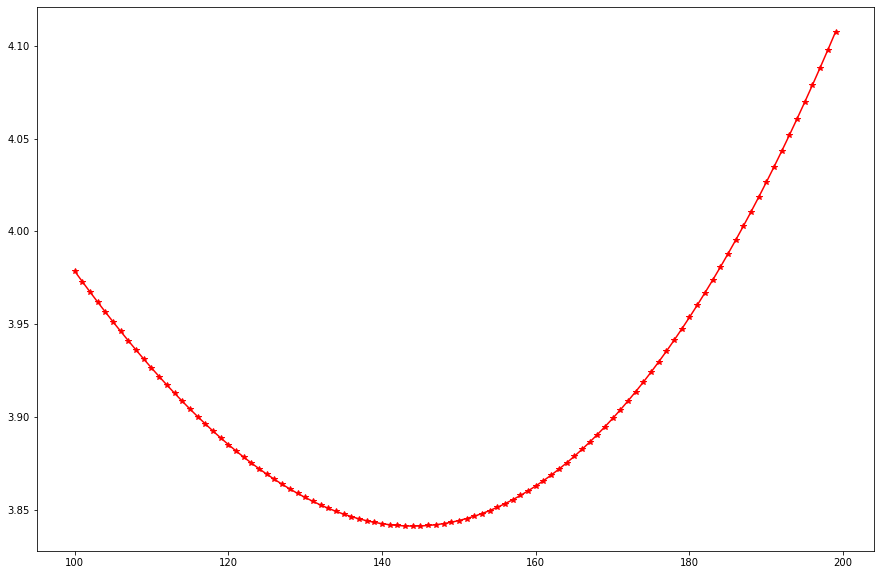

In [123]:
data_list=[df_1_corr,df_2_corr,df_5_corr,df_10_corr]#,df_20_corr]
def MRS(Q):

    #рассчитываем значения theta (работы спекания) для заданной энергии активации
    theta_list_norm=[]
    for i in data_list:
        theta_list_norm.append(theta_calculation(i,Q))
    
    #создаем отдельную таблицу со значениями относительной плотности и соответсвующими значениями
    #работы спекания у каждой кривой для этой плотности
    columns=['Rel Density', 'Theta_1','Theta_2','Theta_5','Theta_10']#,'Theta_20']
    theta_data=pd.DataFrame(columns=columns)
    po_0=0.68
    po_f=0.84
    dens=np.linspace(po_0,po_f,50)
    for j in range(len(dens)):
        list=[]
        list.append(dens[j])
        for k in data_list:
            list.append(k.loc[k.index[k['Rel Density']>dens[j]][0],['Theta']].values[0])
        theta_data.loc[j]=list
    
    MRS=error_function(theta_data,po_0,po_f)
    #print(Q, MRS)
    return MRS

#рассчитываем MRS для набора энергий
MRS_list=[]
Q=np.arange(100000,200000,1000)
for i in Q:
    MRS_list.append(MRS(i))

#выводим результаты: оптимальную энергию и график зависимости MRS от энергии
print('Значение кажущейся энергии активации с наименьшей среднеквадратичной ошибкой: ', Q[MRS_list.index(min(MRS_list))]/1000, 'кДж')
fig,ax=plt.subplots(figsize=(15,10))
ax.plot(Q/1000,MRS_list, color='red',marker='*')
plt.show()

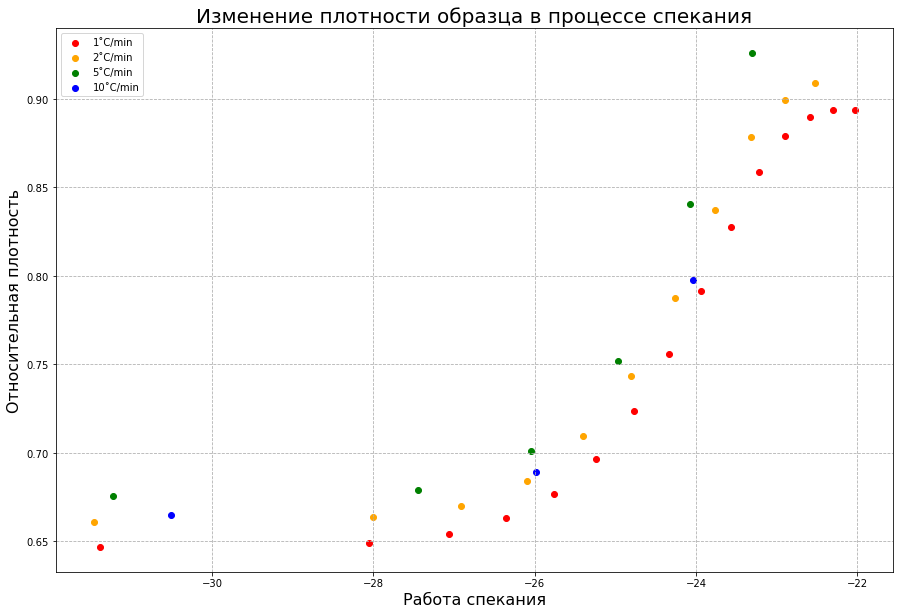

In [119]:
all_rates_theta=[]
Q_min=Q[MRS_list.index(min(MRS_list))]
for data in data_list:
    all_rates_theta.append(theta_calculation(data,Q_min))

fig,ax=plt.subplots(figsize=(15,10))
for data,color,rate in zip(all_rates_theta,colors,rate_list):
    er=range(100,data.shape[0],2000)
    ax.scatter(data.loc[er,'log Theta'],data.loc[er,'Rel Density'], color=color,label=(str(rate)+'˚C/min'))
ax.grid(linestyle='--')
ax.set_title('Изменение плотности образца в процессе спекания', fontsize=20)
ax.set_xlabel('Работа спекания',fontsize=16)
ax.set_ylabel('Относительная плотность',fontsize=16)
plt.legend()
plt.show()